##INSTALLATIONS

In [ ]:
!pip install xgboost

##IMPORTING LIBRARIES

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from scipy.stats import iqr


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

##DATA COLLECTION

In [ ]:
from google.colab import files
files.upload()  # Select the file from your computer

In [71]:
df = pd.read_csv('gcd.csv', index_col=0)

##DATA INSPECTION

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


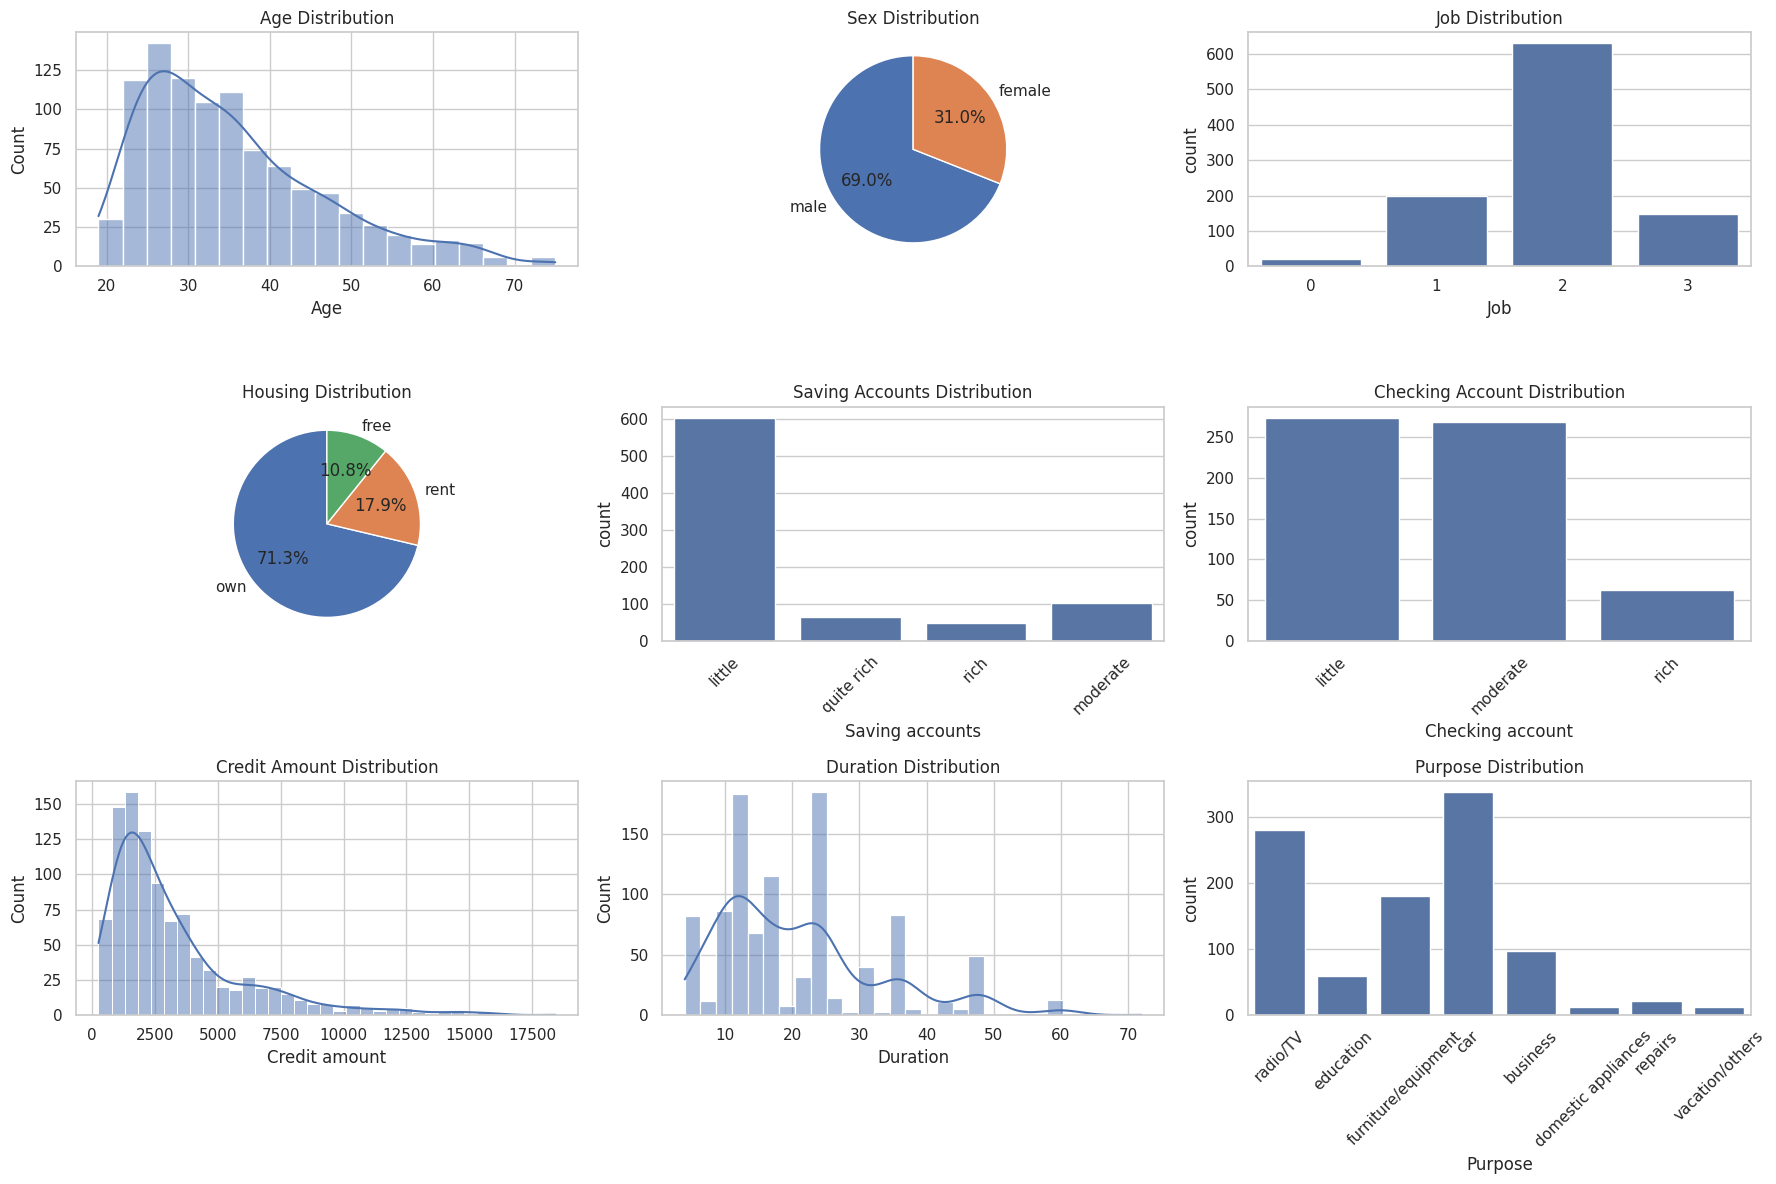

In [73]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Age
sns.histplot(df['Age'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Age Distribution")

# 2. Sex
sex_counts = df['Sex'].value_counts()  # Get counts for 'Sex' categories
axes[0, 1].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Sex Distribution")

# 3. Job
sns.countplot(x='Job', data=df, ax=axes[0, 2])
axes[0, 2].set_title("Job Distribution")

# 4. Housing
housing_counts = df['Housing'].value_counts()  # Get counts for 'Housing' categories
axes[1, 0].pie(housing_counts, labels=housing_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("Housing Distribution")

# 5. Saving Accounts
sns.countplot(x='Saving accounts', data=df, ax=axes[1, 1])
axes[1, 1].set_title("Saving Accounts Distribution")
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Checking Account
sns.countplot(x='Checking account', data=df, ax=axes[1, 2])
axes[1, 2].set_title("Checking Account Distribution")
axes[1, 2].tick_params(axis='x', rotation=45)

# 7. Credit Amount
sns.histplot(df['Credit amount'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title("Credit Amount Distribution")

# 8. Duration
sns.histplot(df['Duration'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title("Duration Distribution")

# 9. Purpose
sns.countplot(x='Purpose', data=df, ax=axes[2, 2])
axes[2, 2].set_title("Purpose Distribution")
axes[2, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [74]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


##DATA CLEANING

In [75]:
for col in df.columns.tolist():
  print (col," : ", df[col].unique())

Age  :  [67 22 49 45 53 35 61 28 25 24 60 32 44 31 48 26 36 39 42 34 63 27 30 57
 33 37 58 23 29 52 50 46 51 41 40 66 47 56 54 20 21 38 70 65 74 68 43 55
 64 75 19 62 59]
Sex  :  ['male' 'female']
Job  :  [2 1 3 0]
Housing  :  ['own' 'free' 'rent']
Saving accounts  :  [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account  :  ['little' 'moderate' nan 'rich']
Credit amount  :  [ 1169  5951  2096  7882  4870  9055  2835  6948  3059  5234  1295  4308
  1567  1199  1403  1282  2424  8072 12579  3430  2134  2647  2241  1804
  2069  1374   426   409  2415  6836  1913  4020  5866  1264  1474  4746
  6110  2100  1225   458  2333  1158  6204  6187  6143  1393  2299  1352
  7228  2073  5965  1262  3378  2225   783  6468  9566  1961  6229  1391
  1537  1953 14421  3181  5190  2171  1007  1819  2394  8133   730  1164
  5954  1977  1526  3965  4771  9436  3832  5943  1213  1568  1755  2315
  1412 12612  2249  1108   618  1409   797  3617  1318 15945  2012  2622
  2337  7057  1469  2323   93

In [76]:
df.columns.tolist()

['Age',
 'Sex',
 'Job',
 'Housing',
 'Saving accounts',
 'Checking account',
 'Credit amount',
 'Duration',
 'Purpose']

##OUTLIER REMOVAL

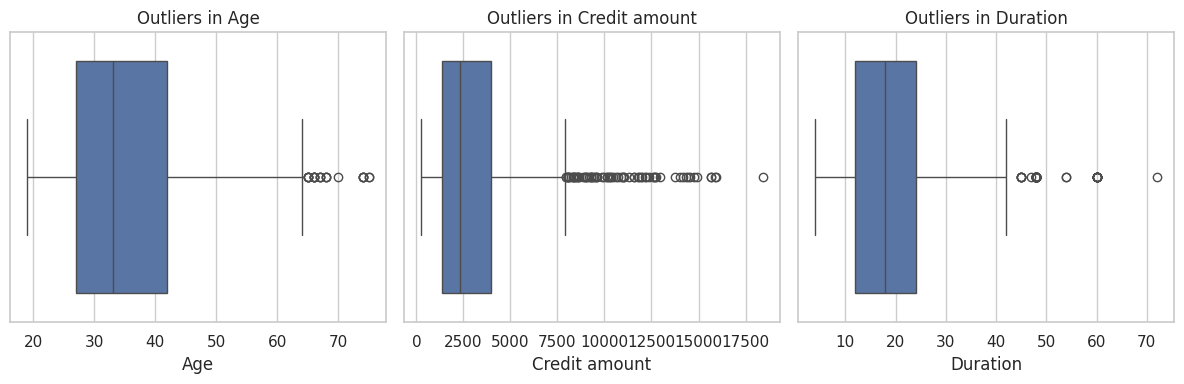

In [77]:
# List of numerical columns in your dataframe
numerical_cols = ['Age', 'Credit amount', 'Duration']

# Create a box plot for each numerical column to visualize outliers
plt.figure(figsize=(12, 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, len(numerical_cols), i)
    sns.boxplot(x=df[col])
    plt.title(f'Outliers in {col}')

plt.tight_layout()
plt.show()

In [78]:
# List of numerical columns
numerical_cols = ['Age', 'Credit amount', 'Duration']

for col in numerical_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = iqr(df[col])
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"Outliers in '{col}': {outliers[col].tolist()}\n")

Outliers in 'Age': [67, 66, 66, 70, 65, 74, 68, 66, 75, 74, 65, 75, 67, 74, 65, 66, 74, 66, 67, 65, 68, 65, 68]

Outliers in 'Credit amount': [9055, 8072, 12579, 9566, 14421, 8133, 9436, 12612, 15945, 11938, 8487, 10144, 8613, 9572, 10623, 10961, 14555, 8978, 12169, 11998, 10722, 9398, 9960, 10127, 11590, 13756, 14782, 14318, 12976, 11760, 8648, 8471, 11328, 11054, 8318, 9034, 8588, 7966, 8858, 12389, 12204, 9157, 15653, 7980, 8086, 10222, 10366, 9857, 14027, 11560, 14179, 12680, 8065, 9271, 9283, 9629, 15857, 8335, 11816, 10875, 9277, 15672, 8947, 10477, 18424, 14896, 12749, 10297, 8358, 10974, 8386, 8229]

Outliers in 'Duration': [48, 48, 60, 45, 48, 48, 48, 54, 54, 48, 48, 60, 48, 48, 45, 48, 48, 60, 48, 48, 47, 48, 48, 48, 48, 48, 48, 60, 48, 60, 60, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 60, 48, 60, 48, 48, 48, 60, 72, 60, 48, 48, 60, 48, 48, 48, 48, 48, 48, 45, 48, 48, 48, 48, 60, 48, 60, 48, 45, 45]



In [79]:
# ASSUMING CREDIT AMOUNT AND DURATION OUTLIERS ARE ACTUALLY VALID WE ARE ONLY REMOVING AGE OUTLIERS
# Drop outliers only for the 'Age' column
Q1, Q3 = df['Age'].quantile(0.25), df['Age'].quantile(0.75)
IQR = iqr(df['Age'])
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df_cleaned = df[(df['Age'] >= lower) & (df['Age'] <= upper)]
print ('Dropped ',df.shape[0]-df_cleaned.shape[0],' data points out of ',df.shape[0], ' : AGE OUTLIERS')

Dropped  23  data points out of  1000  : AGE OUTLIERS


In [80]:
df=df_cleaned

##MISSING VALUES

In [81]:
df.isna().sum()

,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,179
Checking account,389
Credit amount,0
Duration,0
Purpose,0


In [82]:
mode_value = df['Saving accounts'].mode()[0]
df['Saving accounts'].fillna(mode_value, inplace=True)
mode_value_checking = df['Checking account'].mode()[0]  # 'little'
df['Checking account'].fillna(mode_value_checking, inplace=True)

In [83]:
df.isna().sum()

,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,0
Checking account,0
Credit amount,0
Duration,0
Purpose,0


##FEATURE ENGINEERING

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 1 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               977 non-null    int64 
 1   Sex               977 non-null    object
 2   Job               977 non-null    int64 
 3   Housing           977 non-null    object
 4   Saving accounts   977 non-null    object
 5   Checking account  977 non-null    object
 6   Credit amount     977 non-null    int64 
 7   Duration          977 non-null    int64 
 8   Purpose           977 non-null    object
dtypes: int64(4), object(5)
memory usage: 76.3+ KB


In [85]:
df['Float Repayment Age']=df['Age']+df['Duration']/12
df['Repayment Age'] = np.ceil(df['Float Repayment Age']).astype('int64')

In [86]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Float Repayment Age,Repayment Age
1,22,female,2,own,little,moderate,5951,48,radio/TV,26.0,26
2,49,male,1,own,little,little,2096,12,education,50.0,50
3,45,male,2,free,little,little,7882,42,furniture/equipment,48.5,49
4,53,male,2,free,little,little,4870,24,car,55.0,55
5,35,male,1,free,little,little,9055,36,education,38.0,38


In [87]:
# Assuming Sex is not affecting the risk anyway
df = df.drop(columns=['Sex','Age','Duration','Float Repayment Age'], axis=1)

In [90]:
df.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Purpose,Repayment Age
1,2,own,little,moderate,5951,radio/TV,26
2,1,own,little,little,2096,education,50
3,2,free,little,little,7882,furniture/equipment,49
4,2,free,little,little,4870,car,55
5,1,free,little,little,9055,education,38


##Pipelining Encoding and Scaling

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 1 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Job               977 non-null    int64 
 1   Housing           977 non-null    object
 2   Saving accounts   977 non-null    object
 3   Checking account  977 non-null    object
 4   Credit amount     977 non-null    int64 
 5   Purpose           977 non-null    object
 6   Repayment Age     977 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 61.1+ KB


In [96]:
df['Purpose'].unique()

array(['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others'], dtype=object)

In [137]:
# Define the column names for each preprocessing step
housing_column = ['Housing']
ordinal_columns = ['Saving accounts', 'Checking account', 'Purpose']
scaling_columns = ['Credit amount', 'Repayment Age']

# Define the ordinal encoding mapping for each of the columns
ordinal_mapping = {
    'Saving accounts': ['little', 'moderate','quite rich' , 'rich'],
    'Checking account': ['little', 'moderate', 'rich'],
    'Purpose': ['repairs', 'vacation/others', 'furniture/equipment', 'domestic appliances', 'radio/TV', 'car', 'education', 'business']
}

# Create the preprocessing steps for each type of transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,drop='first'), housing_column),  # One hot encoding for 'Housing' (dropping one column)
        ('ordinal', OrdinalEncoder(categories=[ordinal_mapping[col] for col in ordinal_columns]), ordinal_columns),  # Ordinal encoding for 'Saving accounts', 'Checking account', and 'Purpose'
        ('scaler', RobustScaler(), scaling_columns)  # Robust scaling for 'Credit amount' and 'Repayment Age'
    ],
        remainder='passthrough'  # Keep other columns unchanged
)
preprocessor.set_output(transform='pandas')  # Set the output format to pandas DataFrame


# Create the pipeline that applies the transformations
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


*EXAMPLE CODE FOR CONVERTING NDARRAY TO DATAFRAME AFTER PIPELINE*

In [127]:
### EXAMPLE CODE
df_transformed = pipeline.fit_transform(df)
# Get the transformed column names
transformed_column_names = list(preprocessor.get_feature_names_out())
transformed_column_names = list(map(lambda x: x.split('_')[-1], transformed_column_names))

print (transformed_column_names)
transformed_df = pd.DataFrame(df_transformed, columns=transformed_column_names)
transformed_df.head()

['own', 'rent', 'Saving accounts', 'Checking account', 'Purpose', 'Credit amount', 'Repayment Age', 'Job']


,own,rent,Saving accounts,Checking account,Purpose,Credit amount,Repayment Age,Job
0,1.0,0.0,0.0,1.0,4.0,1.396459,-0.642857,2.0
1,1.0,0.0,0.0,0.0,6.0,-0.087375,1.071429,1.0
2,0.0,0.0,0.0,0.0,2.0,2.139723,1.000000,2.0
3,0.0,0.0,0.0,0.0,5.0,0.980370,1.428571,2.0
4,0.0,0.0,0.0,0.0,6.0,2.591224,0.214286,1.0


##Check Correlation for Feature Selection

In [142]:
df_copy = df.copy()
df_copy = pipeline.fit_transform(df_copy)

# Get the transformed column names
# transformed_column_names = list(preprocessor.get_feature_names_out())
# transformed_column_names = list(map(lambda x: x.split('_')[-1], transformed_column_names))
# df_copy = pd.DataFrame(df_copy, columns=transformed_column_names)
df_copy.head()

,onehot__Housing_own,onehot__Housing_rent,ordinal__Saving accounts,ordinal__Checking account,ordinal__Purpose,scaler__Credit amount,scaler__Repayment Age,remainder__Job
1,1.0,0.0,0.0,1.0,4.0,1.396459,-0.642857,2
2,1.0,0.0,0.0,0.0,6.0,-0.087375,1.071429,1
3,0.0,0.0,0.0,0.0,2.0,2.139723,1.000000,2
4,0.0,0.0,0.0,0.0,5.0,0.980370,1.428571,2
5,0.0,0.0,0.0,0.0,6.0,2.591224,0.214286,1


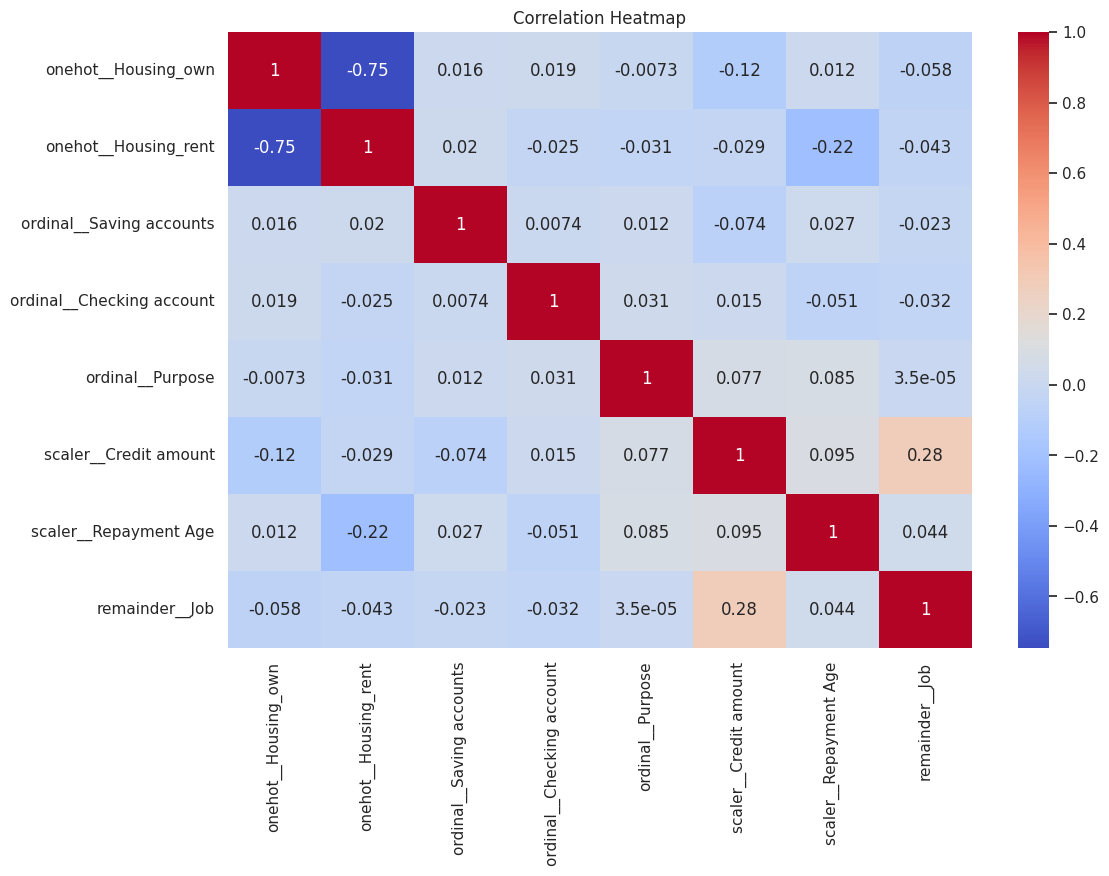

In [145]:
# Creaing Heat Map
corr = df_copy.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Adding Dependant Variable (RISK)

In [146]:
# Since RISK is not given we are adding risk variable and putting values based on some assumptions
df.head()

,Job,Housing,Saving accounts,Checking account,Credit amount,Purpose,Repayment Age
1,2,own,little,moderate,5951,radio/TV,26
2,1,own,little,little,2096,education,50
3,2,free,little,little,7882,furniture/equipment,49
4,2,free,little,little,4870,car,55
5,1,free,little,little,9055,education,38


##EDA

##SPLIT DATA INTO X AND y

##MODEL SELECTION

##HYPERPARAMETER TUNING

##EXPORT MODEL AND PIPELINE